<a href="https://colab.research.google.com/github/enscully/AWS_Geospatial/blob/main/Lake_Mead_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*Pre-req: Google Earth Engine account which is free*

## **Process:**
1. Connect to Earth Engine and pull from the Landsat 8 satellite for the Lake Mead area
2. After getting one image to work, pull a "collection" of several images over a specified time period
3. Convert the image objects (Earth Engine data type) to 3D numpy arrays with RGB bands/channels
  - Why? The Earth Engine image objects store the data in a hidden way. You can click through the different parameters and bands, but this is not compatible with neural networks (or any other models you would want to apply)
4. Export the arrays for each date available
##### *---Complete up to this point---*
5. Use the arrays to train a neural network to identify the border of Lake Mead
6. Using the border, calculate surface area
7. Plot surface area over time

## **Unexpected findings/issues:**
1. Overall, it is pretty difficult to extract the RGB channels from the image object in a meaningful way
  - I had to try multiple different ways before finally finding one that worked over the area of interest
  - The area of interest was too large to export all at once, so I tried alternative methods such as "slicing" the area up into multiple smaller squares. Though this then allowed me to pull all the data I needed, the shapes of the objects were *similar* but not *identical* which is an obvious issue if I were to then try to match the pieces back up to each other. I tried several different ways of getting the squares to each be the same shape, or even the same shape in one dimension, with no success. An example of this is pulling 10 squares where the X dimension shape was 347 for some squares and 348 or 349 for others.
  - Another issue with the RGB channels from the Landsat 8 satellite is that they are captured in 12-bit and then upscaled to 16-bit (not sure of any of the details for how this works, that's just what they say in the documentation). The reason this is problematic is because RGB plot expect values between 0-255 which is 8 bit. I needed to do a lot of research to see what the appropriate transformation was for the specific satellite and channels I was using. The coordinate reference system (CRS) also came into play here because the transformation was dependent on the type of projection (which I also needed to find).
2. Inititally it seemed that I would need to extract each RGB channel independently to be able to stay under the pixel limit for data extraction from the image. However, once the 16- to 8-bit transformation was straightened out and cross checked, I was able to pull all three channels together for the entire area
3. Earth Engine "image" and "image collection" objects are not intuitive and a big learning curve
4. There is a measurement called the Modified Normalized Difference Water Index (MNDWI) which is a simple way to quickly extract and highlight water features. Similar equations exist for vegitation and urban features! The formula is:
> MNDWI = (Green – SWIR) / (Green + SWIR)

  which can be translated to the following with Landsat bands:
> (Band 3 – Band 6) / (Band 3 + Band 6)

  The MNDWI ranges between -1 and 1, and values > 0.5 are generally water features. In a future extenstion you could calculate this over a specified area over time and count the number of pixels over a specified threshold, then divide the water pixels over the total pixels to get a "percent water" value. Then track this value over time. Since this doesn't have much application to non-water images, I decided not to try it.






# Get images working on the area of interest

In [ ]:
!pip install earthengine-api --upgrade -q
!pip install eemont geemap -q

In [2]:
import eemont
import geemap

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

In [4]:
roi = ee.Geometry.Point([-114.762293, 36.06462])

In [5]:
images = (
    ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
    .filterBounds(roi)
    .filterDate('2015-01-01', '2022-12-31')
    .maskClouds() # Makes clouds empty pixels
    .sort('CLOUD_COVER')
)

In [6]:
print(images.size().getInfo())

158


In [7]:
best_image = images.first()

In [8]:
best_image.select('B.+')

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.setCenter(-114.762293, 36.06462, 9)
Map

In [10]:
vis_params = {
    'bands': ['B5', 'B4', 'B3'],
    'min': 0,
    'max': 6000,
    'gamma': 1.4,
}
Map.addLayer(best_image.select('B.+'), vis_params, 'Best image')

# Apply to images over time

In [11]:
roi = ee.Geometry.Point([-114.762293, 36.06462])

# region = ee.Geometry.Polygon(
#     [[[-114.080428, 36.002173],
#       [-114.838485, 36.002173], 
#       [-114.838485, 36.458568], 
#       [-114.080428, 36.458568]]], proj = None, geodesic = False
# )

In [31]:
images = (
    ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
    .filterBounds(roi.buffer(10))
    .filterDate('2010-01-01', '2022-12-31')
    # .maskClouds()
    .sort('CLOUD_COVER')
)

images = images.filter(ee.Filter.lessThan('CLOUD_COVER', 20))

In [32]:
print(images.size().getInfo()) # Number of images available

138


In [33]:
best_image = images.first() # Since images are sorted based on cloud cover, first image is least cloudy
best_image

In [34]:
listOfImages = images.toList(images.size()) # Another way to get the first image, but can get any image
firstImage = ee.Image(listOfImages.get(0))
firstImage
firstImage.select("B+")

In [ ]:
Map = geemap.Map()
Map.setCenter(-114.762293, 36.06462, 9)
Map

In [17]:
vis_params = {
    'bands': ['B5', 'B4', 'B3'],
    'min': 0,
    'max': 6000,
    'gamma': 1.4,
}
Map.addLayer(firstImage.select('B.+'), vis_params, 'Best image')

Found this code on one of the tutorials for how to save images but was able to adapt it for the numpy array feature. Notice the values are not 0-255

In [ ]:
import io
import requests
import ee

region = ee.Geometry.Polygon(
    [[[-114.080428, 36.002173],
      [-114.838485, 36.002173], 
      [-114.838485, 36.458568], 
      [-114.080428, 36.458568]]], proj = None, geodesic = False
)

# Image chunk as a NumPy structured array.
import numpy
url = best_image.getDownloadUrl({
    'bands': ['B5'],
    'region': region,
    'scale': 20,
    'format': 'NPY'
})
response = requests.get(url)
data = numpy.load(io.BytesIO(response.content))
print(data)

Once I got it working, I was able to pull each band individually and then combine them together into a 3D array. Note the definitions for crs and the rescaling to 256. Bands 4, 3, and 2 correspond to RGB respectively

In [19]:
import io
import requests
import ee
import numpy as np
import matplotlib.pyplot as plt

region = ee.Geometry.Polygon(
    [[[-114.080428, 36.002173],
      [-114.838485, 36.002173], 
      [-114.838485, 36.458568], 
      [-114.080428, 36.458568]]], proj = None, geodesic = False
)

In [20]:
url = ee.Image(listOfImages.get(100)).multiply(0.0002).multiply(256).uint8().getDownloadUrl({
    'bands': ['B4'],
    'region': region,
    "crs": "EPSG:32611",
    "crs_transform": [30, 0, 584085, 0, -30, 4106415],
    'format': 'NPY'
})
response = requests.get(url)
data = numpy.load(io.BytesIO(response.content))
data_unstr4 = np.array(data.tolist())

In [21]:
url = ee.Image(listOfImages.get(100)).multiply(0.0002).multiply(256).uint8().getDownloadUrl({
    'bands': ['B3'],
    'region': region,
    "crs": "EPSG:32611",
    "crs_transform": [30, 0, 584085, 0, -30, 4106415],
    'format': 'NPY'
})
response = requests.get(url)
data = numpy.load(io.BytesIO(response.content))
data_unstr3 = np.array(data.tolist())

In [22]:
url = ee.Image(listOfImages.get(100)).multiply(0.0002).multiply(256).uint8().getDownloadUrl({
    'bands': ['B2'],
    'region': region,
    "crs": "EPSG:32611",
    "crs_transform": [30, 0, 584085, 0, -30, 4106415],
    'format': 'NPY'
})
response = requests.get(url)
data = numpy.load(io.BytesIO(response.content))
data_unstr2 = np.array(data.tolist())

In [23]:
result = np.concatenate((data_unstr4, data_unstr3, data_unstr2), axis=2)

In [24]:
result.shape

(1749, 2317, 3)

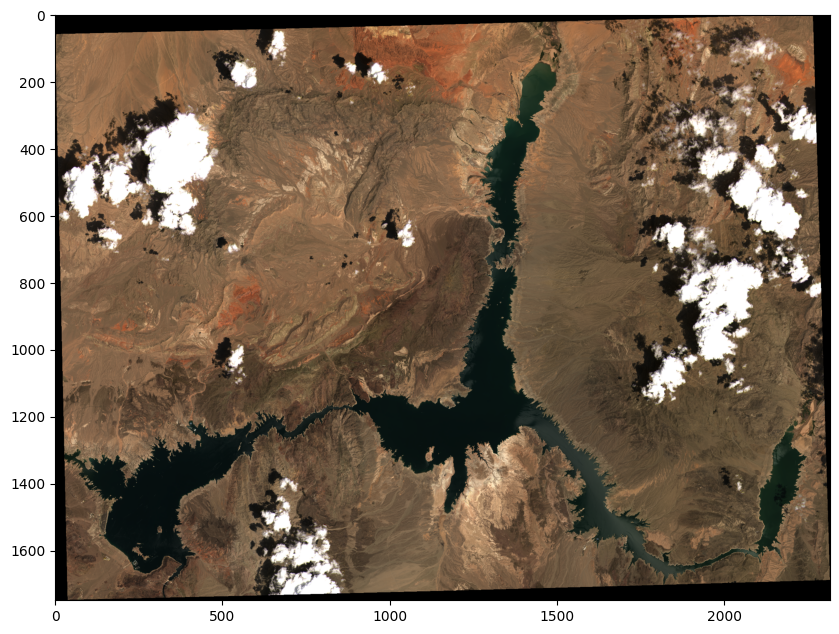

In [25]:
plt.figure(figsize = (10,10))
plt.imshow(result)
plt.show()

Once I confirmed everything was working correctly, I made a loop to extract all the images over the time period to numpy arrays and then save the arrays to my drive. Images are saved with the date they were taken in the name for reference when re-loaded for modeling

In [ ]:
# for img_num in range(0, len(listOfImages)):
for img_num in range(0, 2):
  for band in ["B4", "B3", "B2"]:
    url = ee.Image(listOfImages.get(img_num)).multiply(0.0002).multiply(256).uint8().getDownloadUrl({
        'bands': [band],
        'region': region,
        "crs": "EPSG:32611",
        "crs_transform": [30, 0, 584085, 0, -30, 4106415],
        'format': 'NPY'
    })
    response = requests.get(url)
    data = numpy.load(io.BytesIO(response.content))

    if band == "B4":
      data_unstr4 = np.array(data.tolist())

    elif band == "B3":
      data_unstr3 = np.array(data.tolist())

    else:
      data_unstr2 = np.array(data.tolist())

  result = np.concatenate((data_unstr4, data_unstr3, data_unstr2), axis=2)

  date_save = ee.Image(listOfImages.get(img_num)).date().format('MM-dd-yyyy').getInfo()

  numpy.save(f"/content/drive/MyDrive/lakeMead/img{date_save}.npy", result)

  print("Img num: ", img_num)
  print("Shape", result.shape)



When I tested the loop above on the first 2 images, it took about 30 seconds. With 158 images, the loop would take about 30 minutes. I started looking for a faster way, then found that now I could pull all the bands together because of the scaling I had to do to get 0-255

In [26]:
url = ee.Image(listOfImages.get(3)).multiply(0.0002).multiply(256).uint8().getDownloadUrl({
    'bands': ["B7", "B6", "B5", "B4", "B3", "B2"],
    'region': region,
    "crs": "EPSG:32611",
    "crs_transform": [30, 0, 584085, 0, -30, 4106415],
    'format': 'NPY'
})
response = requests.get(url)
data = numpy.load(io.BytesIO(response.content))

In [27]:
data = np.array(data.tolist())

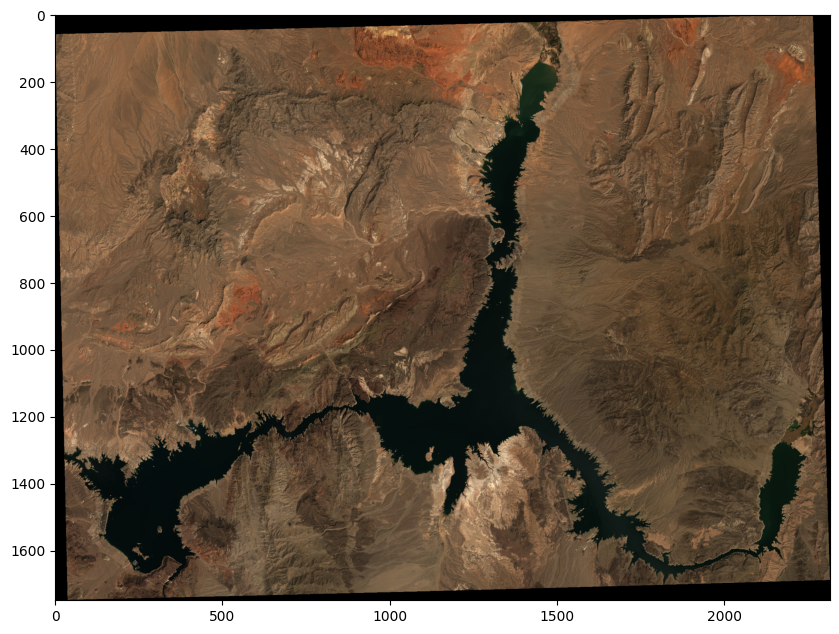

In [28]:
plt.figure(figsize = (10,10))
plt.imshow(data[:,:,3:6])
plt.show()

138

In [38]:
roi = ee.Geometry.Point([-114.762293, 36.06462])


In [44]:
images = (
    ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
    .filterBounds(roi.buffer(10))
    .filterDate('2010-01-01', '2023-12-31')
    # .maskClouds()
    # .sort('CLOUD_COVER')
)

images = images.filter(ee.Filter.lessThan('CLOUD_COVER', 20))

In [45]:
listOfImages = images.toList(images.size()) # Another way to get the first image, but can get any image

In [46]:
len(listOfImages)

138

In [ ]:
for img_num in range(0, len(listOfImages)):
# for img_num in range(0, 2):
  url = ee.Image(listOfImages.get(img_num)).multiply(0.0002).multiply(256).uint8().getDownloadUrl({
      'bands': ["B7", "B6", "B5", "B4", "B3", "B2"],
      'region': region,
      "crs": "EPSG:32611",
      "crs_transform": [30, 0, 584085, 0, -30, 4106415],
      'format': 'NPY'
  })
  response = requests.get(url)
  result = numpy.load(io.BytesIO(response.content))

  result = np.array(result.tolist())

  date_save = ee.Image(listOfImages.get(img_num)).date().format('MM-dd-yyyy').getInfo()

  print(date_save)

  numpy.save(f"/content/drive/MyDrive/lakeMead/img{date_save}.npy", result)

  print("Img num: ", img_num)
  print("Shape", result.shape)



In [ ]:
"B7", "B6", "B5", "B4", "B3", "B2"
(5 - 7)/(5 + 7)
(3 - 6) / (3 + 6)
(6 - 5) / (6 + 5)

In [ ]:
MNDVI = (data[:,:,2] - data[:,:,0]) / (data[:,:,2] + data[:,:,0])

In [ ]:
MNDWI = (data[:,:,4] - data[:,:,1]) / (data[:,:,4] + data[:,:,1])

In [ ]:
NDBI = (data[:,:,1] - data[:,:,2]) / (data[:,:,1] + data[:,:,2])

In [ ]:
import pandas as pd

In [ ]:
melt_df_MNDVI = pd.DataFrame(MNDVI).melt().drop('variable',axis=1).rename({'value':'A'},axis=1)
melt_df_MNDWI = pd.DataFrame(MNDWI).melt().drop('variable',axis=1).rename({'value':'A'},axis=1)
melt_df_NDBI = pd.DataFrame(NDBI).melt().drop('variable',axis=1).rename({'value':'A'},axis=1)

In [ ]:
((melt_df_NDBI < 0) & (melt_df_MNDWI > 0)).sum()

A    325006
dtype: int64

In [ ]:
(melt_df_MNDWI > 0).sum()

A    365317
dtype: int64

### CNN

In [146]:
import numpy as np
import matplotlib.pyplot as plt

In [147]:
img_1 = np.load("/content/drive/MyDrive/lakeMead/img01-05-2018.npy")
img_2 = np.load("/content/drive/MyDrive/lakeMead/img01-10-2014.npy")
img_3 = np.load("/content/drive/MyDrive/lakeMead/img01-11-2020.npy")

In [148]:
def getClasses(data):
  MNDVI = np.where((data[:,:,2] + data[:,:,0]) == 0, 0, (data[:,:,2] - data[:,:,0]) / (data[:,:,2] + data[:,:,0]))
  MNDWI = np.where((data[:,:,4] + data[:,:,1]) == 0, 0, (data[:,:,4] - data[:,:,1]) / (data[:,:,4] + data[:,:,1]))
  NDBI = np.where((data[:,:,1] + data[:,:,2]) == 0, 0, (data[:,:,1] - data[:,:,2]) / (data[:,:,1] + data[:,:,2]))
  return np.concatenate((data[:,:,3:6], MNDVI[:, :, np.newaxis], MNDWI[:, :, np.newaxis], NDBI[:, :, np.newaxis]), axis=2)

In [149]:
with np.errstate(invalid='ignore', divide='ignore'):
  getClasses(img_1)

In [ ]:
data = img_1
MNDVI = np.where((data[:,:,2] + data[:,:,0]) == 0, 0, (data[:,:,2] - data[:,:,0]) / (data[:,:,2] + data[:,:,0]))
MNDWI = np.where((data[:,:,4] + data[:,:,1]) == 0, 0, (data[:,:,4] - data[:,:,1]) / (data[:,:,4] + data[:,:,1]))
NDBI = np.where((data[:,:,1] + data[:,:,2]) == 0, 0, (data[:,:,1] - data[:,:,2]) / (data[:,:,1] + data[:,:,2]))

The classification result is based on NDVI threshold value
to classify non-vegetation (-1 to 0.1999), low vegetation
(0. 2to 0.5) and high vegetation (0.501 to 1.0). 

In [153]:
MNDVI_new = np.copy(MNDVI)

In [154]:
MNDVI_new[(MNDVI < 0.2)] = 1
MNDVI_new[(MNDVI >= 0.2) & (MNDVI <= 0.5)] = 2
MNDVI_new[(MNDVI > 0.5)] = 3

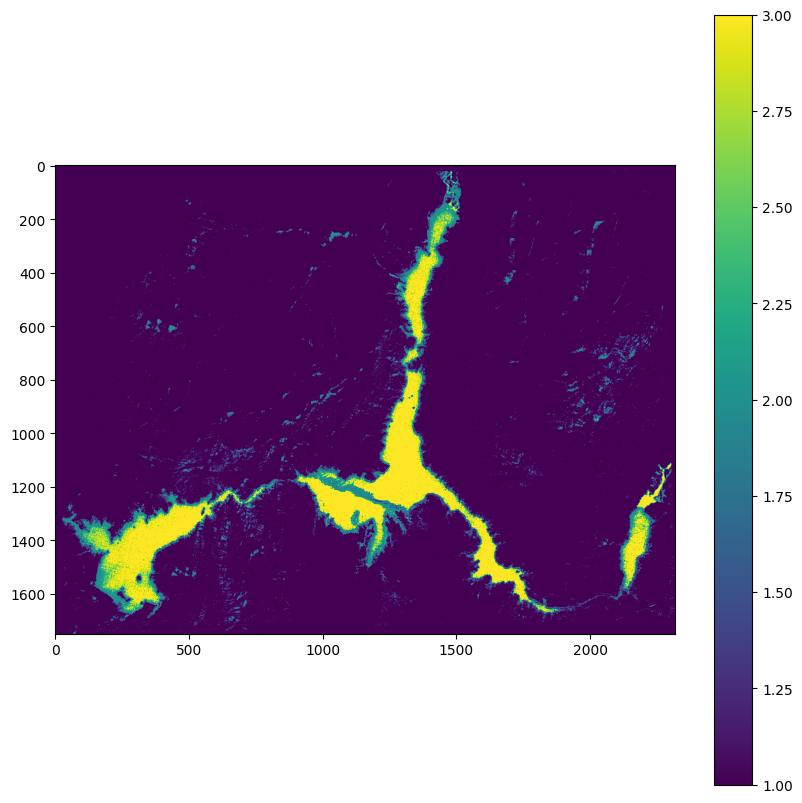

In [155]:
plt.figure(figsize = (10,10))
plt.imshow(MNDVI_new)
plt.colorbar()
plt.show()

The NDWI values correspond to the following ranges:

 * 0,2 – 1 – Water surface,
 * 0.0 – 0,2 – Flooding, humidity,
 * -0,3 – 0.0 – Moderate drought, non-aqueous surfaces,
 * -1 – -0.3 – Drought, non-aqueous surfaces


In [156]:
MNDWI_new = np.copy(MNDWI)

In [157]:
MNDWI_new[(MNDWI < 0)] = 1
MNDWI_new[(MNDWI >= 0) & (MNDWI <= 0.2)] = 2
MNDWI_new[(MNDWI > 0.2)] = 3

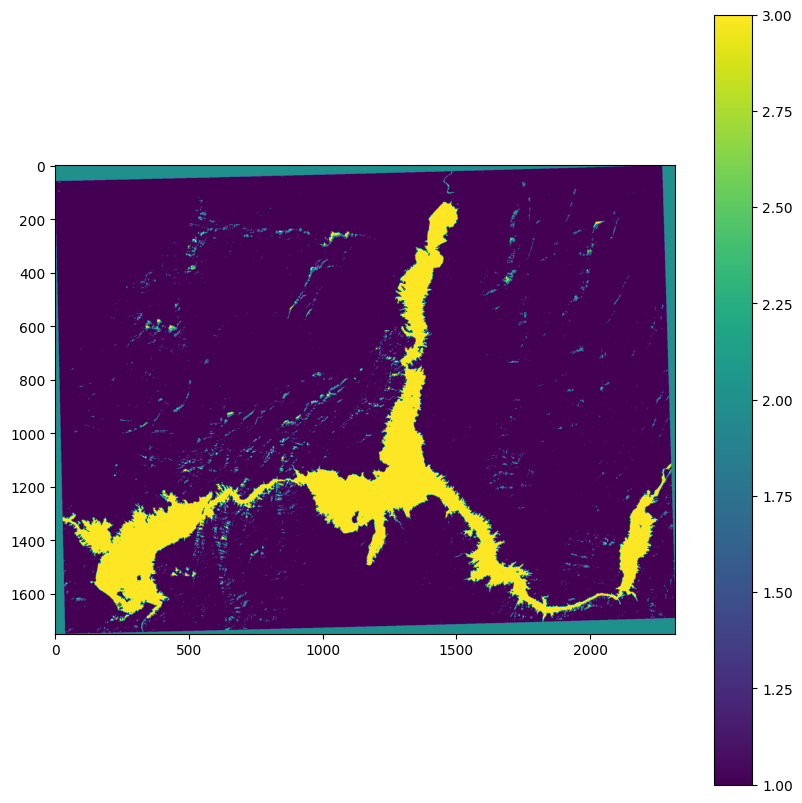

In [158]:
plt.figure(figsize = (10,10))
plt.imshow(MNDWI_new)
plt.colorbar()
plt.show()

Positive values of NDBI represent urban land areas and negative values of NDBI represent non-urban land areas

In [159]:
NDBI_new = np.copy(NDBI)

In [160]:
NDBI_new[(NDBI <= 0)] = 1 # non-urban
NDBI_new[(NDBI > 0)] = 2 # urban

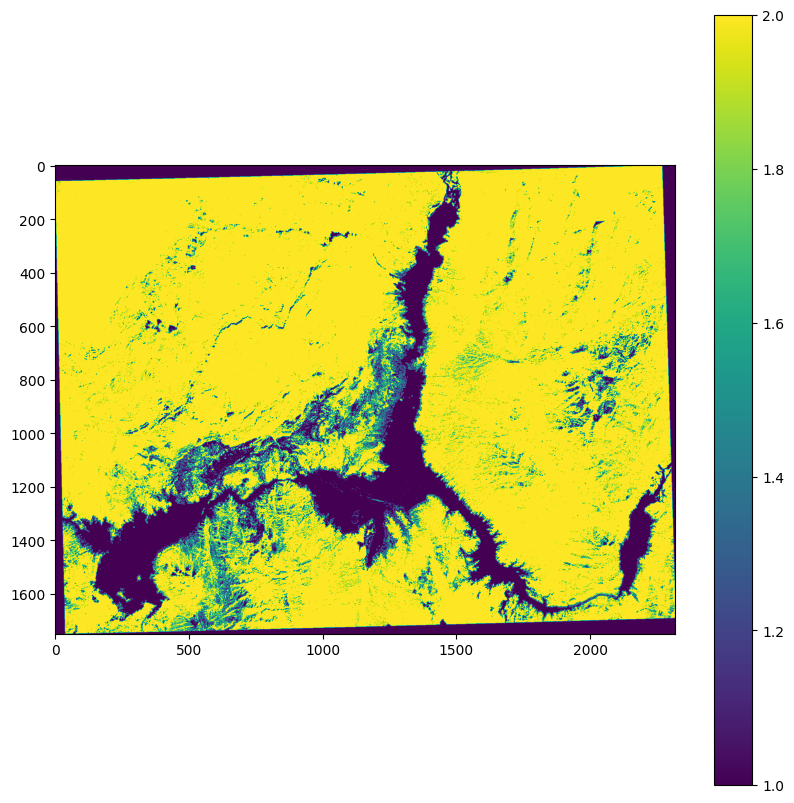

In [161]:
plt.figure(figsize = (10,10))
plt.imshow(NDBI_new)
plt.colorbar()
plt.show()

In [162]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [163]:
# Define the labels for classification
labels = ["water", "land", "building"]

# Create a dictionary to map labels to integer values
label_map = {label: i for i, label in enumerate(labels)}

In [171]:
# Define the size of the input image
img_size = img_1.shape

# Define the number of output classes
num_classes = len(labels)

In [172]:
img_1.shape

(1749, 2317, 6)

In [ ]:
# Define the CNN model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=img_size))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:





# Convert the label_map dictionary to an array of integers
label_array = np.array([label_map[label] for label in labels])

# Convert the label_array to one-hot encoded vectors
from tensorflow.keras.utils import to_categorical
label_one_hot = to_categorical(label_array, num_classes)

# Train the model
model.fit(image_array, label_one_hot, epochs=10, batch_size=32)

# Use the model to predict land cover types of a new satellite image
new_image = np.load("new_image.npy")
predictions = model.predict(new_image)
predicted_labels = [labels[np.argmax(pred)] for pred in predictions]
print(predicted_labels)
